In [16]:
!sudo apt-get install megatools -q
!megadl "https://mega.nz/file/HYdgnBRR#rKVPCWZ81MxQuwi_Loy3C1_QatIczNIdUJHphXESmT4" --path="/content/file.obj"

Reading package lists...
Building dependency tree...
Reading state information...
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Downloaded Head_01_Decimated.OBJ


In [17]:
# @title Setup and Blender Installation { display-mode: "form" }
import os
import sys
import subprocess
import time
from google.colab import files
from IPython.display import display, Image

# --- Parameters ---
# Choose a Blender version (check blender.org/download/lts/ for stable LTS versions)
# Or find latest releases at blender.org/download/
BLENDER_VERSION = "4.1.1" # Example: Use a recent stable version
BLENDER_MAJOR_MINOR = ".".join(BLENDER_VERSION.split(".")[:2]) # e.g., "4.1"

# --- Check GPU ---
print("Checking GPU availability...")
try:
    gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'])
    gpu_name = gpu_info.decode('ascii').strip()
    print(f"GPU detected: {gpu_name}")
    if "T4" not in gpu_name:
        print("Warning: GPU is not a Tesla T4, but proceeding anyway.")
except FileNotFoundError:
    print("Error: nvidia-smi command not found. Is GPU runtime enabled?")
    print("Ensure you have selected Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU")
    sys.exit("GPU not available.")
except Exception as e:
    print(f"Error checking GPU: {e}")
    sys.exit("GPU check failed.")

# --- Download and Extract Blender ---
blender_folder_name = f"blender-{BLENDER_VERSION}-linux-x64"
blender_archive_name = f"{blender_folder_name}.tar.xz"
blender_download_url = f"https://download.blender.org/release/Blender{BLENDER_MAJOR_MINOR}/{blender_archive_name}"
blender_executable_path = os.path.join(blender_folder_name, "blender")
blender_install_dir = "/content/blender" # Installation directory

if not os.path.exists(blender_executable_path):
    print(f"Downloading Blender {BLENDER_VERSION}...")
    # Use aria2c for potentially faster downloads (install if needed)
    try:
      subprocess.run(['apt-get', 'update'], check=True, capture_output=True)
      subprocess.run(['apt-get', 'install', '-y', 'aria2'], check=True, capture_output=True)
      download_cmd = ['aria2c', '-x', '16', '-s', '16', '-k', '1M', blender_download_url]
      print("Using aria2c for download.")
    except Exception:
      print("aria2c not available or failed to install, using wget.")
      download_cmd = ['wget', blender_download_url]

    subprocess.run(download_cmd, check=True)

    print("Extracting Blender...")
    # Using tar command for extraction
    subprocess.run(['tar', '-xf', blender_archive_name], check=True)
    print("Blender extracted.")

    # Optional: Move to a cleaner path (avoids long names in commands)
    # if os.path.exists(blender_install_dir):
    #    subprocess.run(['rm', '-rf', blender_install_dir])
    # subprocess.run(['mv', blender_folder_name, blender_install_dir])
    # blender_executable_path = os.path.join(blender_install_dir, "blender")
    # print(f"Blender moved to {blender_install_dir}")


else:
    print("Blender already downloaded and extracted.")

print(f"Blender executable path: {blender_executable_path}")
# Verify execution permission
subprocess.run(['chmod', '+x', blender_executable_path], check=True)

# --- Check Blender Version ---
try:
    blender_version_output = subprocess.run([f'./{blender_executable_path}', '--version'], capture_output=True, text=True, check=True)
    print("\n--- Blender Version Check ---")
    print(blender_version_output.stdout)
    print("---------------------------\n")
except subprocess.CalledProcessError as e:
    print(f"Error running Blender version check: {e}")
    print(f"Stderr: {e.stderr}")
    sys.exit("Blender execution failed.")
except FileNotFoundError:
    print(f"Error: Blender executable not found at {blender_executable_path}")
    sys.exit("Blender executable missing.")

print("Setup complete.")

# --- OBJ to BLEND Conversion ---
print("\n--- Converting OBJ to BLEND ---")

# Define file paths
obj_file_path = "/content/file.obj"
blend_file_path = "/content/file.blend"

# Check if OBJ file exists
if not os.path.exists(obj_file_path):
    print(f"Error: OBJ file not found at {obj_file_path}")
    sys.exit("OBJ file missing.")

# Create a Python script for Blender to execute
conversion_script = """
import bpy
import sys

# Clear existing mesh objects
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete()

# Import OBJ file
obj_path = sys.argv[-2]
blend_path = sys.argv[-1]

print(f"Importing OBJ from: {obj_path}")
bpy.ops.wm.obj_import(filepath=obj_path)

# Save as BLEND file
print(f"Saving BLEND file to: {blend_path}")
bpy.ops.wm.save_as_mainfile(filepath=blend_path)

print("Conversion complete!")
"""

# Write the conversion script to a temporary file
conversion_script_path = "/content/convert_obj_to_blend.py"
with open(conversion_script_path, 'w') as f:
    f.write(conversion_script)

# Run Blender in background mode with the conversion script
print(f"Converting {obj_file_path} to {blend_file_path}...")
try:
    # Run Blender in background mode (no UI) with Python script
    cmd = [
        f'./{blender_executable_path}',
        '--background',  # Run without UI
        '--python', conversion_script_path,
        '--',  # Separator for script arguments
        obj_file_path,
        blend_file_path
    ]

    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("Blender output:")
    print(result.stdout)

    if os.path.exists(blend_file_path):
        file_size = os.path.getsize(blend_file_path) / (1024 * 1024)  # Size in MB
        print(f"\nSuccess! BLEND file created: {blend_file_path}")
        print(f"File size: {file_size:.2f} MB")
    else:
        print("Error: BLEND file was not created.")

except subprocess.CalledProcessError as e:
    print(f"Error during conversion: {e}")
    print(f"Stdout: {e.stdout}")
    print(f"Stderr: {e.stderr}")
except Exception as e:
    print(f"Unexpected error: {e}")

# Clean up temporary script
if os.path.exists(conversion_script_path):
    os.remove(conversion_script_path)

print("\n--- Conversion Process Complete ---")

# Optional: Download the BLEND file
# Uncomment the following line if you want to automatically download the converted file
# files.download(blend_file_path)


Checking GPU availability...
GPU detected: Tesla T4
Blender already downloaded and extracted.
Blender executable path: blender-4.1.1-linux-x64/blender

--- Blender Version Check ---
Blender 4.1.1
	build date: 2024-04-15
	build time: 23:47:45
	build commit date: 2024-04-15
	build commit time: 15:11
	build hash: e1743a0317bc
	build platform: Linux
	build type: Release
	build c flags:  -Wall -Werror=implicit-function-declaration -Wstrict-prototypes -Werror=return-type -Werror=vla -Wmissing-prototypes -Wno-char-subscripts -Wno-unknown-pragmas -Wpointer-arith -Wunused-parameter -Wwrite-strings -Wlogical-op -Wundef -Winit-self -Wmissing-include-dirs -Wno-div-by-zero -Wtype-limits -Wformat-signedness -Wrestrict -Wno-stringop-overread -Wno-stringop-overflow -Wnonnull -Wabsolute-value -Wuninitialized -Wredundant-decls -Wshadow -Wimplicit-fallthrough=5 -Wno-error=unused-but-set-variable  -std=gnu11 -msse -pipe -fPIC -funsigned-char -fno-strict-aliasing -ffp-contract=off -msse2  
	build c++ flags

In [19]:
# @title Specify and Verify Existing .blend File { display-mode: "form" }

import os

# --- Define the path to your existing .blend file ---
# Modify this string if your file is located elsewhere in the Colab environment
blend_file_path = "/content/file.blend"

print(f"INFO: Attempting to use specified .blend file: {blend_file_path}")

# --- Verify that the file exists at the specified path ---
if os.path.exists(blend_file_path):
    # If the file exists, print a success message.
    # The variable 'blend_file_path' now holds the valid path and can be used by the next cell.
    print(f"SUCCESS: Found file at '{blend_file_path}'.")
    print("You can now proceed to run the next cell (Configure Render Settings and Generate Preview).")
else:
    # If the file does not exist, print an error message and instructions.
    print(f"\nERROR: File not found at the specified path '{blend_file_path}'.")
    print("Please ensure that 'file.blend' exists in the '/content/' directory.")
    print("---------------------------------------------------------------------")
    print("How to fix:")
    print("1. Check the spelling and exact path: Is it '/content/file.blend'?")
    print("2. Upload the file: Use the file browser panel on the left side of Colab (folder icon).")
    print("   - Click the 'Upload' button (upward arrow icon) and select your 'file.blend'.")
    print("   - Wait for the upload to complete.")
    print("3. Re-run this cell after uploading or correcting the path.")
    print("---------------------------------------------------------------------")

    # Set blend_file_path to None. The next code cell checks this variable,
    # preventing it from attempting to render a non-existent file.
    blend_file_path = None

# Optional: You can uncomment the line below to list files in /content/ for debugging
# print("\nFiles currently in /content/:", os.listdir('/content/'))

INFO: Attempting to use specified .blend file: /content/file.blend
SUCCESS: Found file at '/content/file.blend'.
You can now proceed to run the next cell (Configure Render Settings and Generate Preview).



==================== RENDERING PREVIEW: 1_Slightly_Closer_Original_Target ====================
Settings: Distance=3.5, Target Z-Height=0.0
--- Blender Output ---
Device | Writing constant memory
Fra:1 Mem:220.68M (Peak 220.68M) | Time:00:01.23 | Mem:53.80M, Peak:53.80M | Scene, ViewLayer | Loading denoising kernels (may take a few minutes the first time)
Fra:1 Mem:224.68M (Peak 224.68M) | Time:00:01.24 | Mem:393.81M, Peak:393.81M | Scene, ViewLayer | Sample 0/32
Fra:1 Mem:254.40M (Peak 254.40M) | Time:00:01.25 | Remaining:00:00.31 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 1/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.70 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 32/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.70 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Finished
Saved: '/content/renders/file_1_Slightly_Closer_Original_Target.png'
Time: 00:06.20 (Saving: 00:00.41)

Executing Blender Python script...
No active camera found, creating a new one.


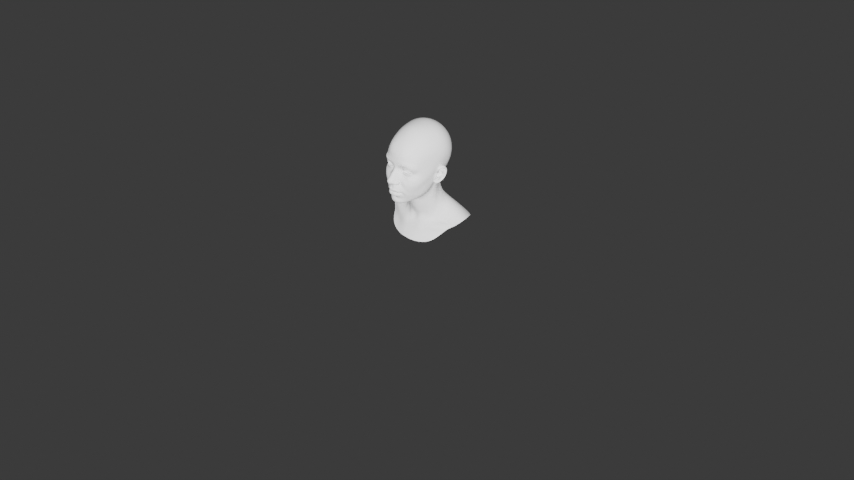


==================== RENDERING PREVIEW: 2_Slightly_Closer_Aiming_Higher ====================
Settings: Distance=3.5, Target Z-Height=0.25
--- Blender Output ---
g Device | Writing constant memory
Fra:1 Mem:220.68M (Peak 220.68M) | Time:00:02.03 | Mem:53.80M, Peak:53.80M | Scene, ViewLayer | Loading denoising kernels (may take a few minutes the first time)
Fra:1 Mem:224.68M (Peak 224.68M) | Time:00:02.04 | Mem:393.81M, Peak:393.81M | Scene, ViewLayer | Sample 0/32
Fra:1 Mem:254.40M (Peak 254.40M) | Time:00:02.05 | Remaining:00:00.32 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 1/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:06.05 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 32/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:06.05 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Finished
Saved: '/content/renders/file_2_Slightly_Closer_Aiming_Higher.png'
Time: 00:06.34 (Saving: 00:00.22)

Executing Blender Python script...
No active camera found, creating a new one.
C

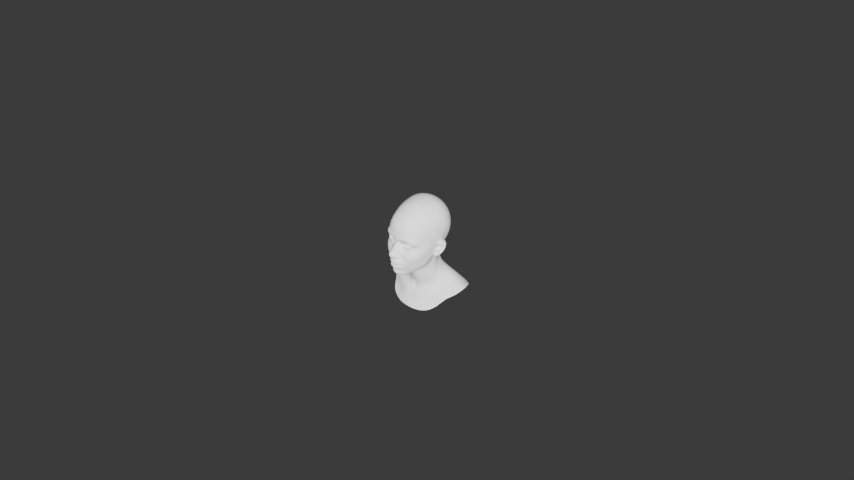


==================== RENDERING PREVIEW: 3_Closer_And_Aiming_Higher ====================
Settings: Distance=3.0, Target Z-Height=0.4
--- Blender Output ---
dating Device | Writing constant memory
Fra:1 Mem:220.68M (Peak 220.68M) | Time:00:01.16 | Mem:53.80M, Peak:53.80M | Scene, ViewLayer | Loading denoising kernels (may take a few minutes the first time)
Fra:1 Mem:224.68M (Peak 224.68M) | Time:00:01.16 | Mem:393.81M, Peak:393.81M | Scene, ViewLayer | Sample 0/32
Fra:1 Mem:254.40M (Peak 254.40M) | Time:00:01.17 | Remaining:00:00.31 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 1/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.72 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 32/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.72 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Finished
Saved: '/content/renders/file_3_Closer_And_Aiming_Higher.png'
Time: 00:06.16 (Saving: 00:00.35)

Executing Blender Python script...
No active camera found, creating a new one.
Camera 

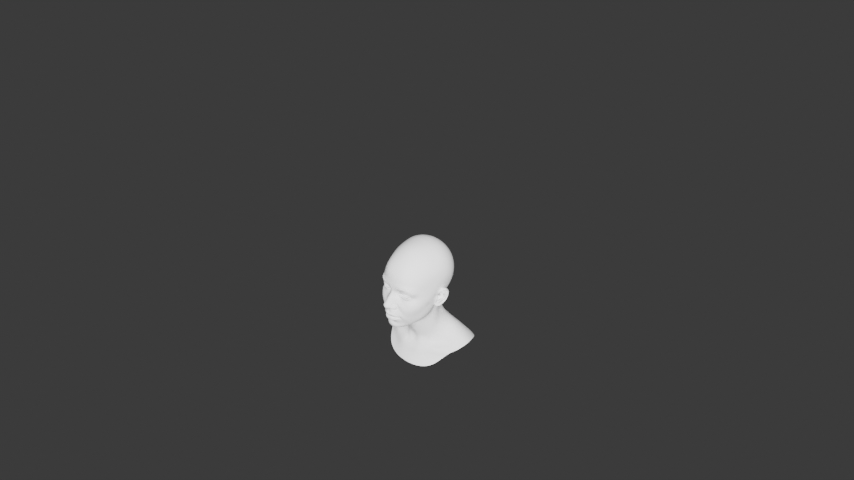


==================== RENDERING PREVIEW: 4_Closer_And_Aiming_Much_Higher ====================
Settings: Distance=3.0, Target Z-Height=0.6
--- Blender Output ---
g Device | Writing constant memory
Fra:1 Mem:220.68M (Peak 220.68M) | Time:00:01.55 | Mem:53.80M, Peak:53.80M | Scene, ViewLayer | Loading denoising kernels (may take a few minutes the first time)
Fra:1 Mem:224.68M (Peak 224.68M) | Time:00:01.56 | Mem:393.81M, Peak:393.81M | Scene, ViewLayer | Sample 0/32
Fra:1 Mem:254.40M (Peak 254.40M) | Time:00:01.57 | Remaining:00:00.31 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 1/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.55 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 32/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.55 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Finished
Saved: '/content/renders/file_4_Closer_And_Aiming_Much_Higher.png'
Time: 00:05.84 (Saving: 00:00.22)

Executing Blender Python script...
No active camera found, creating a new one.
Ca

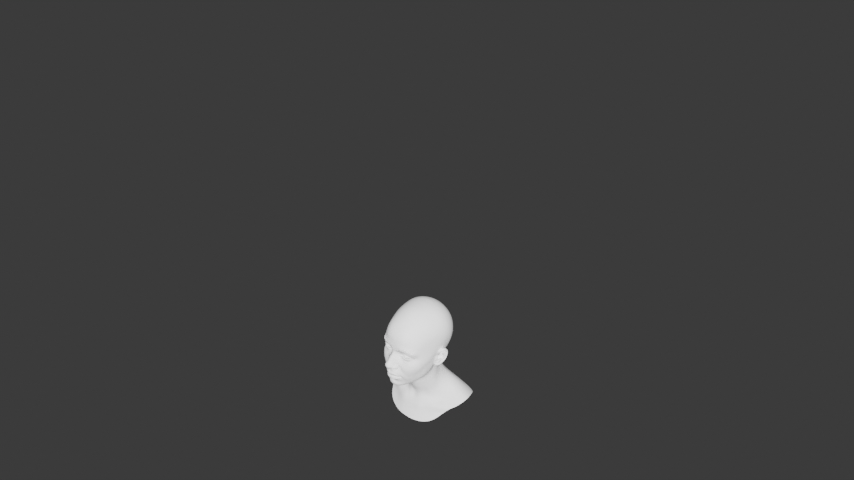


==================== RENDERING PREVIEW: 5_Original_Distance_Aiming_Higher ====================
Settings: Distance=4.0, Target Z-Height=0.5
--- Blender Output ---
Device | Writing constant memory
Fra:1 Mem:220.68M (Peak 220.68M) | Time:00:01.15 | Mem:53.80M, Peak:53.80M | Scene, ViewLayer | Loading denoising kernels (may take a few minutes the first time)
Fra:1 Mem:224.68M (Peak 224.68M) | Time:00:01.16 | Mem:393.81M, Peak:393.81M | Scene, ViewLayer | Sample 0/32
Fra:1 Mem:254.40M (Peak 254.40M) | Time:00:01.17 | Remaining:00:00.28 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 1/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.41 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Sample 32/32
Fra:1 Mem:266.91M (Peak 285.68M) | Time:00:05.41 | Mem:423.52M, Peak:423.52M | Scene, ViewLayer | Finished
Saved: '/content/renders/file_5_Original_Distance_Aiming_Higher.png'
Time: 00:06.03 (Saving: 00:00.54)

Executing Blender Python script...
No active camera found, creating a new one.


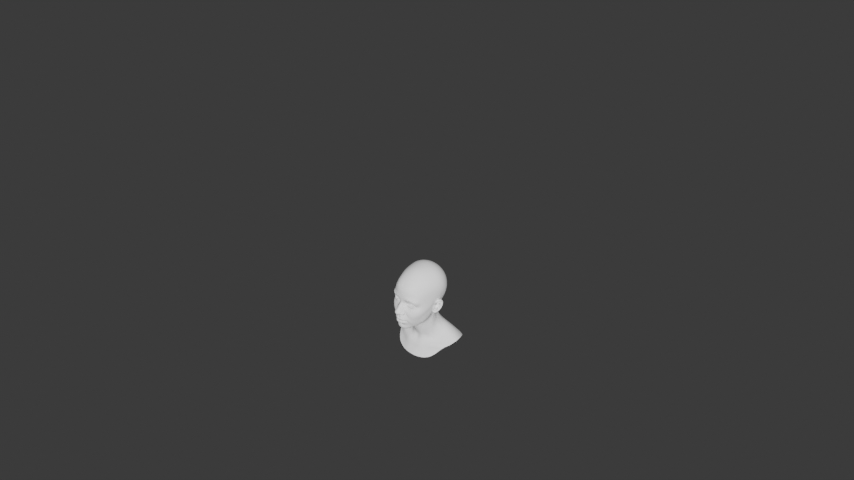


All previews generated.


In [42]:
# @title Configure Render Settings and Generate 5 Previews

if not blend_file_path or not os.path.exists(blend_file_path):
    print("Error: No .blend file specified or found. Please run the previous cell first.")
else:
    # --- Multi-Preview Configuration ---
    # We will test five different camera setups.
    # 'distance': How far the camera is. Smaller is closer.
    # 'target_z': The vertical point the camera aims at.
    #             - A positive value tells the camera to aim HIGHER.
    #             - A zero value aims at the world origin.
    #             - A negative value aims LOWER.
    configurations = [
        { "title": "1_Slightly_Closer_Original_Target", "distance": 3.5, "target_z": 0.0 },
        { "title": "2_Slightly_Closer_Aiming_Higher",  "distance": 3.5, "target_z": 0.25 },
        { "title": "3_Closer_And_Aiming_Higher",       "distance": 3.0, "target_z": 0.4 },
        { "title": "4_Closer_And_Aiming_Much_Higher",  "distance": 3.0, "target_z": 0.6 },
        { "title": "5_Original_Distance_Aiming_Higher","distance": 4.0, "target_z": 0.5 },
    ]

    # --- General Render Configuration ---
    output_dir = "/content/renders"
    os.makedirs(output_dir, exist_ok=True)
    blend_filename_base = os.path.splitext(os.path.basename(blend_file_path))[0]

    render_engine = "CYCLES"
    resolution_x = 854  # 480p at 16:9 aspect ratio
    resolution_y = 480
    samples = 32        # Lower samples for fast previews
    use_gpu = True
    add_light = True
    light_energy = 1000

    # --- Loop Through Configurations and Render ---
    for config in configurations:
        current_title = config["title"]
        camera_distance = config["distance"]
        camera_target_z = config["target_z"]

        print(f"\n{'='*20} RENDERING PREVIEW: {current_title} {'='*20}")
        print(f"Settings: Distance={camera_distance}, Target Z-Height={camera_target_z}")

        output_filename = f"{blend_filename_base}_{current_title}.png"
        output_filepath = os.path.join(output_dir, output_filename)

        # --- Create the Blender Python Script ---
        render_script_content = f"""
import bpy, sys, os, mathutils, math

print("Executing Blender Python script...")

args = sys.argv[sys.argv.index('--') + 1:]
if len(args) < 8:
    print("Error: Not enough arguments.")
    print("Expected: output, engine, res_x, res_y, samples, light_energy, cam_dist, cam_target_z")
    sys.exit(1)

output_path, engine, res_x, res_y, render_samples = args[0], args[1], int(args[2]), int(args[3]), int(args[4])
light_power, cam_distance, cam_target_z = float(args[5]), float(args[6]), float(args[7])
add_light_flag, use_gpu_flag = {add_light}, {use_gpu}

scene = bpy.context.scene
active_camera = None

if not scene.camera:
    print("No active camera found, creating a new one.")
    cam_data = bpy.data.cameras.new(name="AddedCameraData")
    active_camera = bpy.data.objects.new(name="AddedCamera", object_data=cam_data)
    scene.collection.objects.link(active_camera)
    scene.camera = active_camera
else:
    active_camera = scene.camera
    print(f"Using existing camera: '{{active_camera.name}}'")

if not active_camera:
    print("FATAL: Could not determine active camera.")
    sys.exit(1)

# --- THIS IS THE KEY MODIFICATION ---
# 1. Define the point to look at, using the new target_z parameter
target_point = mathutils.Vector((0.0, 0.0, cam_target_z))

# 2. Set camera position based on distance and a fixed angle
offset_direction = mathutils.Vector((1.0, -1.0, 1.0)).normalized()
active_camera.location = target_point + offset_direction * cam_distance

# 3. Point the camera towards the target point
direction_vector = target_point - active_camera.location
active_camera.rotation_euler = direction_vector.to_track_quat('-Z', 'Y').to_euler()
print(f"Camera aimed at {{target_point}} from position {{active_camera.location}}")

if add_light_flag:
    light_data = bpy.data.lights.new(name="AddedLightData", type='POINT')
    light_data.energy = light_power
    light_obj = bpy.data.objects.new(name="AddedPointLight", object_data=light_data)
    light_obj.location = active_camera.location
    scene.collection.objects.link(light_obj)

scene.render.engine = engine
scene.render.filepath = output_path
scene.render.image_settings.file_format = 'PNG'
scene.render.resolution_x = res_x
scene.render.resolution_y = res_y

if use_gpu_flag and engine == 'CYCLES':
    scene.cycles.device = 'GPU'
    prefs = bpy.context.preferences.addons['cycles'].preferences
    prefs.compute_device_type = 'CUDA'
    prefs.get_devices()
    for device in prefs.devices:
        device.use = device.type == 'CUDA'
    scene.cycles.samples = render_samples

print("\\nStarting render...")
bpy.ops.render.render(write_still=True)
print("Render finished successfully.")
"""

        # --- Write script and build command ---
        script_path = "/content/render_script.py"
        with open(script_path, "w") as f:
            f.write(render_script_content)

        command = [
            f'./{blender_executable_path}', '-b', blend_file_path, '-P', script_path, '--',
            output_filepath, render_engine, str(resolution_x), str(resolution_y),
            str(samples), str(light_energy), str(camera_distance), str(camera_target_z)
        ]

        # --- Execute Blender and Display ---
        try:
            render_process = subprocess.run(command, capture_output=True, text=True, check=True)
            print("--- Blender Output ---")
            print(render_process.stdout[-1000:]) # Print last bit of output

            if os.path.exists(output_filepath):
                print(f"✔️ Preview '{current_title}' saved.")
                # Display Title and Image
                print(f"--- PREVIEW: {current_title} ---")
                display(Image(filename=output_filepath))
            else:
                print(f"❌ Error: Output file '{output_filepath}' not found after rendering.")
                if render_process.stderr: print(f"Stderr:\n{render_process.stderr}")

        except subprocess.CalledProcessError as e:
            print(f"\n❌ --- Blender Error for '{current_title}' --- ❌")
            print(e.stderr)

    print("\nAll previews generated.")

Render script saved to /content/render_script.py

--- Running Blender ---
Command: ./blender-4.1.1-linux-x64/blender -b /content/file.blend -P /content/render_script.py -- /content/renders/file_preview.png CYCLES 1280 720 64 100 1.5
--- Blender Output ---
Blender 4.1.1 (hash e1743a0317bc built 2024-04-15 23:47:45)
Read blend: "/content/file.blend"
Fra:1 Mem:69.27M (Peak 69.27M) | Time:00:00.20 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Synchronizing object | file
Fra:1 Mem:132.93M (Peak 138.65M) | Time:00:00.56 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Initializing
Fra:1 Mem:132.76M (Peak 138.65M) | Time:00:00.56 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Waiting for render to start
Fra:1 Mem:132.76M (Peak 138.65M) | Time:00:00.56 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Loading render kernels (may take a few minutes the first time)
Fra:1 Mem:132.76M (Peak 154.14M) | Time:00:00.62 | Mem:0.00M, Peak:0.00M | Scene, ViewLayer | Updating Scene
Fra:1 Mem:132.76M (Peak 154.14M) | 

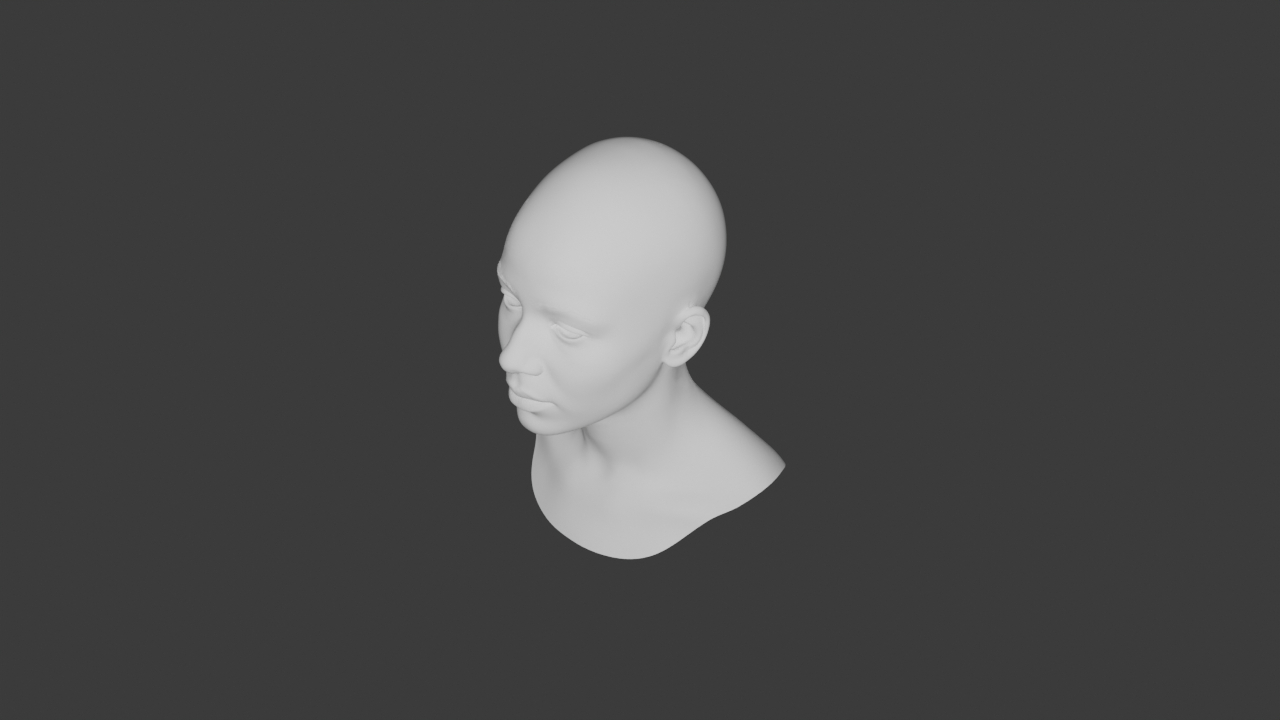

In [47]:
# @title Configure Render Settings and Generate Preview

if not blend_file_path or not os.path.exists(blend_file_path):
    print("Error: No .blend file specified or found. Please run the previous cell first.")
else:
    # --- Render Configuration ---
    output_dir = "/content/renders"
    os.makedirs(output_dir, exist_ok=True)

    # Construct output file path (using blend file name)
    blend_filename_base = os.path.splitext(os.path.basename(blend_file_path))[0]
    output_filename = f"{blend_filename_base}_preview.png" # Change format if needed (JPEG, etc.)
    output_filepath = os.path.join(output_dir, output_filename)

    render_engine = "CYCLES" # Options: "CYCLES", "BLENDER_EEVEE", "BLENDER_WORKBENCH"
    resolution_x = 1280       # Preview width
    resolution_y = 720       # Preview height
    samples = 64            # Reduce for faster previews (Cycles only)
    use_gpu = True          # Use the T4 GPU

    # --- Light Configuration ---
    add_light = True         # Set to False to disable adding the light
    light_energy = 100      # Adjust brightness. Units depend on engine (Cycles: Watts-ish, Eevee: unitless)

    # --- Camera Control ---
    # This variable controls how close the camera is to the object.
    # Smaller numbers = zoom in. Larger numbers = zoom out.
    # A good starting point is between 3 and 8.
    camera_distance = 1.5

    # --- Create the Blender Python Script ---
    # ALL THE LOGIC BELOW, INSIDE THE TRIPLE QUOTES, IS SENT TO BLENDER TO EXECUTE.
    render_script_content = f"""
import bpy
import sys
import os
import mathutils
import math

print("Executing Blender Python script...")

# --- Get arguments passed from Colab ---
args = sys.argv
try:
    arg_start_index = args.index('--') + 1
    script_args = args[arg_start_index:]
except ValueError:
    script_args = []

if len(script_args) < 7:
    print("Error: Not enough arguments passed to the script.")
    print("Expected: output_path, engine, res_x, res_y, samples, light_energy, camera_distance")
    sys.exit(1)

output_path = script_args[0]
engine = script_args[1]
res_x = int(script_args[2])
res_y = int(script_args[3])
render_samples = int(script_args[4])
add_light_flag = {add_light}
light_power = float(script_args[5])
cam_distance = float(script_args[6])
use_gpu_flag = {use_gpu}

# --- Configure Scene ---
scene = bpy.context.scene
active_camera = None # Variable to hold the camera we end up using

# --- Camera Check and Creation ---
if not scene.camera:
    print("No active camera found in the scene. Attempting to add one.")
    if bpy.data.objects.get("Camera"):
        scene.camera = bpy.data.objects["Camera"]
        active_camera = scene.camera
        print(f"Found and set existing 'Camera' as active.")
    else:
        print("No camera objects exist. Creating a new default camera.")
        cam_data = bpy.data.cameras.new(name="AddedCameraData")
        cam_obj = bpy.data.objects.new(name="AddedCamera", object_data=cam_data)
        scene.collection.objects.link(cam_obj)
        scene.camera = cam_obj
        active_camera = cam_obj
        print(f"Added and activated new camera: '{{cam_obj.name}}'")
else:
    active_camera = scene.camera
    print(f"Active camera found: '{{active_camera.name}}'")

if not active_camera:
    print("Error: Could not determine active camera.")
    sys.exit(1)

# <<< THIS IS THE CORRECT LOCATION FOR THE CAMERA LOGIC >>>
# This section repositions BOTH new and existing cameras.
print(f"Positioning camera at a distance of {{cam_distance}} from the origin.")
target_point = mathutils.Vector((0.0, 0.0, 0.2))
offset_direction = mathutils.Vector((1.7, -1.7, 1.7)).normalized()
active_camera.location = target_point + offset_direction * cam_distance
direction_vector = target_point - active_camera.location
rot_quaternion = direction_vector.to_track_quat('-Z', 'Y')
active_camera.rotation_euler = rot_quaternion.to_euler()
print(f"Camera '{{active_camera.name}}' repositioned and aimed at the origin.")

# --- Add Light Source (if enabled) ---
if add_light_flag:
    print(f"Adding a Point light near the camera with energy: {{light_power}}")
    light_data = bpy.data.lights.new(name="AddedLightData", type='POINT')
    light_data.energy = light_power
    light_obj = bpy.data.objects.new(name="AddedPointLight", object_data=light_data)
    light_obj.location = active_camera.location
    scene.collection.objects.link(light_obj)
    print(f"Added light '{{light_obj.name}}' at location {{active_camera.location}}")

# Set Render Engine
scene.render.engine = engine
print(f"Set render engine to: {{engine}}")

# Set Output Path and Format
scene.render.filepath = output_path
scene.render.image_settings.file_format = 'PNG'
print(f"Set output path to: {{output_path}}")

# Set Resolution
scene.render.resolution_x = res_x
scene.render.resolution_y = res_y
scene.render.resolution_percentage = 100
print(f"Set resolution to: {{res_x}}x{{res_y}}")

# --- GPU Configuration ---
if use_gpu_flag and engine == 'CYCLES':
    print("Configuring Cycles for GPU rendering...")
    scene.cycles.device = 'GPU'
    prefs = bpy.context.preferences.addons['cycles'].preferences
    prefs.compute_device_type = 'CUDA'
    prefs.get_devices()
    activated_gpu = False
    for device in prefs.devices:
        if device.type == 'CUDA':
            device.use = True
            print(f"Enabled CUDA device: {{device.name}}")
            activated_gpu = True
        else:
            device.use = False
    if not activated_gpu:
        print("Warning: No CUDA device found/activated. Falling back to CPU.")
        scene.cycles.device = 'CPU'
    scene.cycles.samples = render_samples
    print(f"Set Cycles samples to: {{render_samples}}")
elif use_gpu_flag and engine == 'BLENDER_EEVEE':
    scene.eevee.taa_render_samples = render_samples
    print(f"Set Eevee samples to: {{render_samples}}")

# --- Render ---
print("\\nStarting render...")
bpy.ops.render.render(write_still=True)
print("Render finished successfully!")
print("Blender script finished.")
"""

    # --- Write the script to a file ---
    script_path = "/content/render_script.py"
    with open(script_path, "w") as f:
        f.write(render_script_content)
    print(f"Render script saved to {script_path}")

    # --- Build the Blender Command ---
    command = [
        f'./{blender_executable_path}',
        '-b', blend_file_path,
        '-P', script_path,
        '--',
        output_filepath,
        render_engine,
        str(resolution_x),
        str(resolution_y),
        str(samples),
        str(light_energy),
        str(camera_distance) # Add the camera distance value here
    ]

    # --- Execute Blender ---
    print("\n--- Running Blender ---")
    print(f"Command: {' '.join(command)}")
    start_time = time.time()
    try:
        render_process = subprocess.run(command, capture_output=True, text=True, check=True)
        end_time = time.time()
        print("--- Blender Output ---")
        print(render_process.stdout)
        print("----------------------")
        print(f"Blender executed successfully in {end_time - start_time:.2f} seconds.")

        # --- Display the result ---
        if os.path.exists(output_filepath):
            print(f"\nPreview saved to: {output_filepath}")
            display(Image(filename=output_filepath))
        else:
            print(f"Error: Output file '{output_filepath}' not found after rendering.")
            if render_process.stderr:
                print("--- Blender Error Output ---")
                print(render_process.stderr)

    except subprocess.CalledProcessError as e:
        end_time = time.time()
        print(f"\n--- Blender Error ---")
        print(f"Blender process failed after {end_time - start_time:.2f} seconds with exit code {e.returncode}")
        print("--- Stdout ---")
        print(e.stdout)
        print("--- Stderr ---")
        print(e.stderr)
        print("-------------------")
    except Exception as e:
         print(f"\nAn unexpected error occurred: {e}")